Name: Barış Bilen <br>

# Import

In [1]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from PIL import Image
from pylab import *
from scipy.cluster.vq import *

# Reading Datas and Images

In [2]:
data1 = scipy.io.loadmat('./Exercise_1_data/adjacencyMatrix.mat')  #Q1 data

data2_1 = scipy.io.loadmat('./Exercise_2_data/brainGraph1.mat')["W"]  #Q2, Q3.1 and Q3.2 data
data2_2 = scipy.io.loadmat('./Exercise_2_data/brainGraph2.mat')["W"]  #Q2, Q3.1 and Q3.2 data

image3_1 = Image.open("./Exercise_3_data/image1.jpg")  #Q3.3 and Q3.4 image
image3_2 = Image.open("./Exercise_3_data/image2.jpg")  #Q3.3 and Q3.4 image

# 1 Bellman-Ford shortest path algorithm

## 1.1 Key steps of Bellman-Ford algorithm

### A. Initializing Step:
This step initializes all distances from source to all vertices as infinite. Distance to the source itself initialized as 0.
### B. Calculate Shortest Path (Relaxation of Edges):
This step calculates the shortest distance. For each edge we calculate all possible routes. If the founded route is shorter then the one calculated before we update the distance.
### C. Negative-Weight Cycles:
This steps checks for negative weight cycles. If there is any returns empty array.

## 1.2 Bellman-Ford Function

In [3]:
def BellmanFordAlgo(A, id):
    
    ###--- Initializing Step ---###
    dist = [float("Inf")] * A.shape[0] # Initialize dist matrix with inf values
    dist[id] = 0 # Initialize starting vertice as 0
    prevNode = [None] * A.shape[0]
    
    edgeList = []
    for edge in np.argwhere(A != 0):   # Creating edge list for easy access
        edgeList.append([edge[0], edge[1], A[edge[0],edge[1]]])
        
    ###--- Calculate Shortest Path ---###
    for _ in range(A.shape[0] - 1): # Repating for the number of vertice times
        for u,v,w in edgeList: # For every edge
            if dist[u] != float("Inf") and dist[u] + w < dist[v]: # If distance is smaller
                dist[v] = dist[u] + w # Update distance
                prevNode[v] = u # Update prevNode for output
           
    ###--- Negative-Weight Cycles ---###
    output_matrix = np.zeros((A.shape[0], 3))           
    for u,v,w in edgeList: # For every edge
        if dist[u] != float("Inf") and dist[u] + w < dist[v]: # Check if there is a negative cycle
            print("Negative Cycle")
            return output_matrix
            
    for i in range(A.shape[0]): # Creating output matrix
        output_matrix[i] = [i, dist[i], prevNode[i]]

    return output_matrix

## 1.3 Function Output

In [4]:
print("---Output Array---\n")
print(BellmanFordAlgo(data1["A"], 1))

---Output Array---

[[ 0. inf nan]
 [ 1.  0. nan]
 [ 2. inf nan]
 [ 3.  4.  1.]
 [ 4.  7.  3.]
 [ 5.  5.  3.]]


# 2 Global Efficiency, Diffusion Efficiency and Graph Morphospace

## 2.1 Global Efficiency Function

In [5]:
def globalEfficiency(A, threshold): 

    copiedA = A.copy()
    
    ###---If it is below threshold---###
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            if copiedA[i][j] < threshold:
                copiedA[i][j] = 0  #Change the value to 0

    sum = 0
    for i in range(A.shape[0]):
        shortest_paths = BellmanFordAlgo(copiedA, i) #Calculate the shortest path
        shortest_paths = np.delete(shortest_paths, i, 0) #Deleting self pairs
        
        ###--- Finding Sum of 1 / lij---###
        for j in range(shortest_paths.shape[0]):
            if (1 / shortest_paths[j][1]) != float("Inf"): #If it is not divided by 0
                sum += 1 / shortest_paths[j][1]
    return sum / (A.shape[0] * (A.shape[0] - 1)) #Return to global efficiency

## 2.2 Diffusion Efficiency Function

In [6]:
def diffusionEfficiency(A, threshold):
    copiedA = A.copy()
    
    ###---If it is below threshold---###
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            if copiedA[i][j] < threshold:
                copiedA[i][j] = 0  #Change the value to 0

    node_strengths = np.sum(copiedA, axis=1).reshape(-1,1) #Calculating every nodes strength
    
    ###---Creating strength matrix---###
    matrix_s = np.zeros((A.shape[0],A.shape[0]))
    for i in range(A.shape[0]):
        matrix_s[i][i] = node_strengths[i]
    
    ###---Finding U matrix---###
    inverse_matrix_s = np.linalg.inv(matrix_s)
    matrix_u = np.matmul(copiedA, inverse_matrix_s)
    
    #Creating identity matrix
    identity_matrix = np.identity(A.shape[0])

    sum1 = 0
    for j in range(A.shape[0]):
        copied_matrix_u = matrix_u.copy()
        
        ###---Making j'th row 0 so there is no connection for j'th node---###
        for i in range(A.shape[0]):
            copied_matrix_u[j][i] = 0
        
        ###---Calculation of [1-Uj]^-1---###
        try:
            inverse_matrix = np.linalg.inv(identity_matrix - copied_matrix_u)
        except:
            inverse_matrix = [[float("Inf")]*A.shape[0]]*A.shape[0] #If it is not inversable(singular matrix)
        
        ###--- Finding Sum of 1 / Xij---###
        for h in range(A.shape[0]):
            if j != h :
                sum2 = 0
                for i in range(A.shape[0]):
                    sum2 += inverse_matrix[i][h]
                if (1/sum2) != float("Inf"): #If it is not divided by 0
                    sum1 += 1/sum2

    return sum1 / (A.shape[0] * (A.shape[0] - 1)) #Return to diffusion efficiency

## Creating Threshold Values

In [7]:
threshold_values = np.arange(0.,1,0.1)

## Calculating The Global Efficiencies

In [8]:
globalEfficiency1 = []
globalEfficiency2 = []

###---Calculating global efficiencies for data 1---###
print("---Global Efficiencies for Data 1---")
for threshold in threshold_values:
    efficiency = globalEfficiency(data2_1, threshold,)
    print("For threshold value:", np.round(threshold,1), "Global efficiency is:", np.round(efficiency,5))
    globalEfficiency1.append(efficiency)
    
print("\n", "#"*30 , "\n")

###---Calculating global efficiencies for data 2---###
print("---Global Efficiencies for Data 2---")
for threshold in threshold_values:
    efficiency = globalEfficiency(data2_2, threshold)
    print("For threshold value:", np.round(threshold,1), "Global efficiency is:", np.round(efficiency,5))
    globalEfficiency2.append(efficiency)

---Global Efficiencies for Data 1---
For threshold value: 0.0 Global efficiency is: 59.09231
For threshold value: 0.1 Global efficiency is: 3.88687
For threshold value: 0.2 Global efficiency is: 2.15963
For threshold value: 0.3 Global efficiency is: 1.29259
For threshold value: 0.4 Global efficiency is: 0.79365
For threshold value: 0.5 Global efficiency is: 0.3614
For threshold value: 0.6 Global efficiency is: 0.07481
For threshold value: 0.7 Global efficiency is: 0.01193
For threshold value: 0.8 Global efficiency is: 0.00089
For threshold value: 0.9 Global efficiency is: 0.0

 ############################## 

---Global Efficiencies for Data 2---
For threshold value: 0.0 Global efficiency is: 67.1795
For threshold value: 0.1 Global efficiency is: 3.89946
For threshold value: 0.2 Global efficiency is: 2.11316
For threshold value: 0.3 Global efficiency is: 1.27334
For threshold value: 0.4 Global efficiency is: 0.75103
For threshold value: 0.5 Global efficiency is: 0.36042
For threshold v

## Calculating The Diffusion Efficiencies

In [9]:
diffusionEfficiency1 = []
diffusionEfficiency2 = []

###---Calculating diffusion efficiencies for data 1---###
print("---Diffusion Efficiencies for Data 1---")
for threshold in threshold_values:
    efficiency = diffusionEfficiency(data2_1, threshold)
    print("For threshold value:", np.round(threshold,1), "Diffusion efficiency is:", np.round(efficiency,5))
    diffusionEfficiency1.append(efficiency)
    
print("\n", "#"*30 , "\n")

###---Calculating diffusion efficiencies for data 2---###
print("---Diffusion Efficiencies for Data 2---")
for threshold in threshold_values:
    efficiency = diffusionEfficiency(data2_2, threshold)
    print("For threshold value:", np.round(threshold,1), "Diffusion efficiency is:", np.round(efficiency,5))
    diffusionEfficiency2.append(efficiency)

---Diffusion Efficiencies for Data 1---
For threshold value: 0.0 Diffusion efficiency is: 0.00774
For threshold value: 0.1 Diffusion efficiency is: 0.00763
For threshold value: 0.2 Diffusion efficiency is: 0.0073
For threshold value: 0.3 Diffusion efficiency is: 0.00655
For threshold value: 0.4 Diffusion efficiency is: 0.0
For threshold value: 0.5 Diffusion efficiency is: 0.0
For threshold value: 0.6 Diffusion efficiency is: 0.0
For threshold value: 0.7 Diffusion efficiency is: 0.0
For threshold value: 0.8 Diffusion efficiency is: 0.0
For threshold value: 0.9 Diffusion efficiency is: 0.0

 ############################## 

---Diffusion Efficiencies for Data 2---
For threshold value: 0.0 Diffusion efficiency is: 0.00769
For threshold value: 0.1 Diffusion efficiency is: 0.00756
For threshold value: 0.2 Diffusion efficiency is: 0.00714
For threshold value: 0.3 Diffusion efficiency is: 0.00627
For threshold value: 0.4 Diffusion efficiency is: -0.0
For threshold value: 0.5 Diffusion efficien

## 2.3 - 2.4 Plotting Global and Diffusion Efficiencies

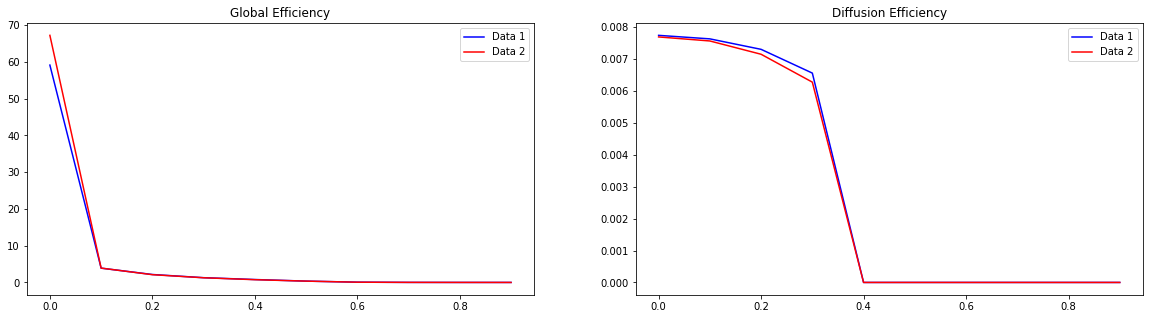

In [10]:
fig, axs = plt.subplots(1,2, figsize=(20, 5))
axs[0].title.set_text("Global Efficiency")
axs[1].title.set_text("Diffusion Efficiency")

###---Plotting Global efficiency---###
axs[0].plot(threshold_values, globalEfficiency1, color="blue", label="Data 1")
axs[0].plot(threshold_values, globalEfficiency2, color="red", label="Data 2")
axs[0].legend()

###---Plotting Diffusion efficiency---###
axs[1].plot(threshold_values, diffusionEfficiency1, color="blue", label="Data 1")
axs[1].plot(threshold_values, diffusionEfficiency2, color="red", label="Data 2")
axs[1].legend()

plt.show()

## 2.5 Conclusions From Above Plots

#### Global Efficiency

From the graph we can say that both data's have the shortest path thresholds at 0.1. After that threshold point shortest path changes drastically. We can also say that second data's global efficiency is higher that first data's which means second data has shorter paths.

#### Diffusion Efficiency

From the graph we can say that both data's have their threshold at 0.4 which correspond to given a random walker arriving to its target after this threshold is most likely not possible.

#### Compare Across Both Graphs

We can say that edges with weight 0.1 and more plays a critical role in finding the shortest path and edges that have weight over 0.4 plays a critical role for graphs connection and efficiency. It is possible after 0.4 threshold, graph might be disconnecting.

## 2.6 Plotting a Morphospace

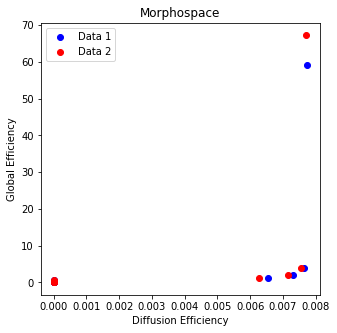

In [11]:
fig, ax = plt.subplots(figsize=(5, 5))

###---Plotting Morphaspace---###
ax.title.set_text("Morphospace")
ax.scatter(diffusionEfficiency1, globalEfficiency1, color="blue", label="Data 1")
ax.scatter(diffusionEfficiency2, globalEfficiency2, color="red", label="Data 2")
ax.set_xlabel("Diffusion Efficiency")
ax.set_ylabel("Global Efficiency")
ax.legend()

plt.show()

## 2.7 Discussing The Information Flow Efficiency

From this graph we can say that whenever diffusion efficiency increases, global efficiency is increasing also. So there is a certain relationship between global and diffusion efficiencies. 

# 3 Graph Self-diffusion for Image Segmentation

## 3.1 Self Diffuse Function

In [12]:
def selfDiffuse(matrix):

    ###---Calculating Smoothing Kernel---###
    matrix_w = matrix.copy()   #Similarity matrix (W)
    
    node_strengths = np.sum(matrix_w, axis=1).reshape(-1,1)
    matrix_strength = np.zeros((matrix.shape[0],matrix.shape[0]))
    for i in range(matrix.shape[0]):
        matrix_strength[i][i] = node_strengths[i] #Diagonal matrix (D)
    
    inverse_matrix_strength = np.linalg.inv(matrix_strength)

    matrix_p = np.matmul(inverse_matrix_strength,matrix_w) #Transition kernel (P)

    ###---Calculation of optimal T*---###
    C = 0.05 #Given in paper caption 4.2
    epsilon = (1.5)*1e-10 #In paper caption 4.2 it is referred as a small positive constant. (Choosen value is vacuum permittivity) 
    matrix_identity = np.identity(matrix.shape[0]) #Identity matrix (I)
    n = matrix.shape[0]
    eigen_values = np.sort(np.linalg.eig(matrix_p)[0])[::-1][1] #Lamda value
    dof = np.trace(matrix_p)
    
    divided = np.log(epsilon / ((n-dof) * (np.linalg.norm(matrix_w - np.matmul(matrix_w, matrix_p) - matrix_identity))))
    diviser = np.log(eigen_values - C)
    t_star = divided/diviser
    t_val = np.linspace(1, 2*int(t_star),5).astype(int)
    t_val[2] = t_star
    ###---Smoothing for T* steps---###
    return_matrix = []
    for t in range(t_val[-1]):
        matrix_w = np.matmul(matrix_w, matrix_p) + matrix_identity

        if (t+1) in t_val:
            return_matrix.append(np.matmul(matrix_w, inverse_matrix_strength))

    return return_matrix, t_val

## 3.2 Visualizing Both Original and Diffused Matrices

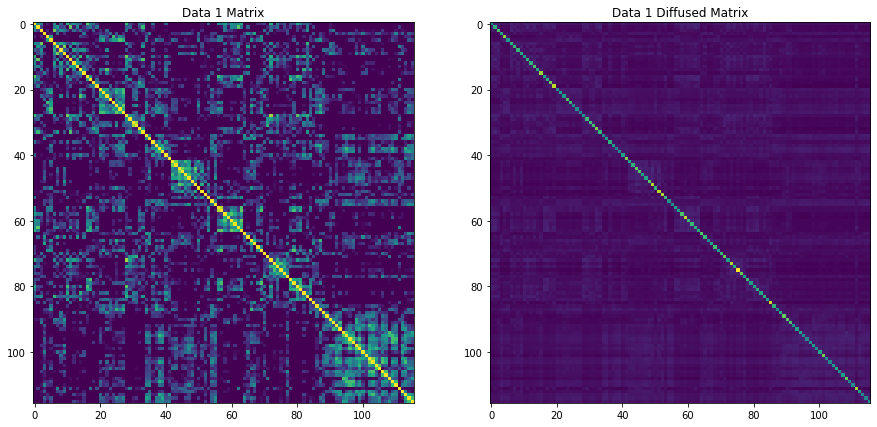

In [13]:
###---Plotting Self Diffuse For Data 1---###
diffusedMatrix1 = selfDiffuse(data2_1.copy())[0]

fig, axs = plt.subplots(1,2, figsize=(15, 10))

axs[0].title.set_text("Data 1 Matrix")
axs[0].imshow(data2_1)
axs[1].title.set_text("Data 1 Diffused Matrix")
axs[1].imshow(diffusedMatrix1[2])

plt.show()

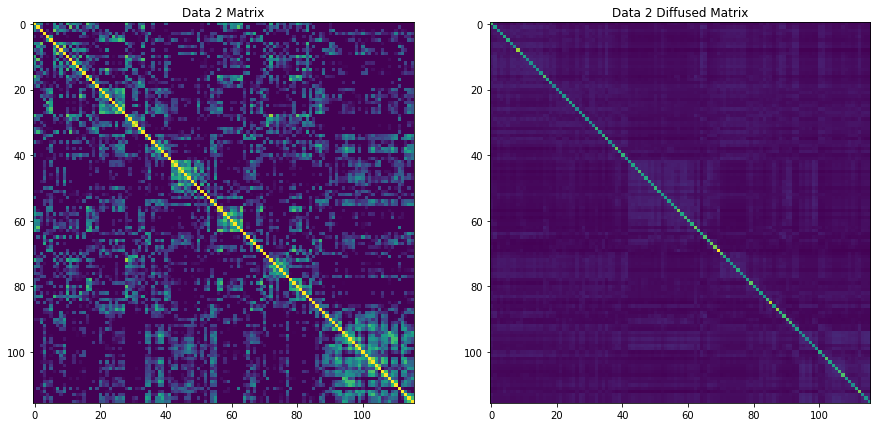

In [14]:
###---Plotting Self Diffuse For Data 2---###
diffusedMatrix2 = selfDiffuse(data2_2.copy())[0]

fig, axs = plt.subplots(1,2, figsize=(15, 10))

axs[0].title.set_text("Data 2 Matrix")
axs[0].imshow(data2_1)
axs[1].title.set_text("Data 2 Diffused Matrix")
axs[1].imshow(diffusedMatrix2[2])

plt.show()

## Normalized Cut Python Code

In [15]:
def ncut_graph_matrix(im,sigma_d=1e2,sigma_g=1e-2):
    """ Create matrix for normalized cut. The parameters are 
        the weights for pixel distance and pixel similarity. """
    
    m,n = im.shape[:2] 
    N = m*n
    
    # normalize and create feature vector of RGB or grayscale
    if len(im.shape)==3:
        for i in range(3):
            im[:,:,i] = im[:,:,i] / im[:,:,i].max()
        vim = im.reshape((-1,3))
    else:
        im = im / im.max()
        vim = im.flatten()
    
    # x,y coordinates for distance computation
    xx,yy = np.meshgrid(range(n),range(m))
    x,y = xx.flatten(),yy.flatten()
    
    # create matrix with edge weights
    W = np.zeros((N,N),'f')
    for i in range(N):
        for j in range(i,N):
            d = (x[i]-x[j])**2 + (y[i]-y[j])**2 
            W[i,j] = W[j,i] = np.exp(-1.0*sum((vim[i]-vim[j])**2)/sigma_g) * np.exp(-d/sigma_d)
    
    return W

In [16]:
def cluster(S,k,ndim):
    """ Spectral clustering from a similarity matrix."""
    
    # create Laplacian matrix
    rowsum = sum(abs(S),axis=0)
    D = np.diag(1 / np.sqrt(rowsum + 1e-6))
    L = np.dot(D,np.dot(S,D))
    
    # compute eigenvectors of L
    U,sigma,V = np.linalg.svd(L,full_matrices=False)
    
    # create feature vector from ndim first eigenvectors
    # by stacking eigenvectors as columns
    features = np.array(V[:ndim]).T

    # k-means
    features = whiten(features)
    centroids,distortion = kmeans(features,k)
    code,distance = vq(features,centroids)
        
    return code,V

## 3.3 Segmantation Map

In [17]:
###--- Resizing Images so it is easy to process---###
size1 = image3_1.copy()
size1 = size1.resize((50,50))
size1 = np.array(size1)/255

size2 = image3_2.copy()
size2 = size2.resize((50,50))
size2 = np.array(size2)/255


ncut_graph_matrix_1 = ncut_graph_matrix(size1)
ncut_graph_matrix_2 = ncut_graph_matrix(size2)

cluster1 = cluster(ncut_graph_matrix_1,7, 25)
cluster2 = cluster(ncut_graph_matrix_2,7, 25)

###---Reshaping the data to Images---###
new_Image1 = cluster1[0].reshape((50,50))
new_Image1 = Image.fromarray(np.uint8(new_Image1))
new_Image1 = new_Image1.resize((image3_1.size[0],image3_1.size[1]))

new_Image2 = cluster2[0].reshape((50,50))
new_Image2 = Image.fromarray(np.uint8(new_Image2))
new_Image2 = new_Image2.resize((image3_2.size[0],image3_2.size[1]))

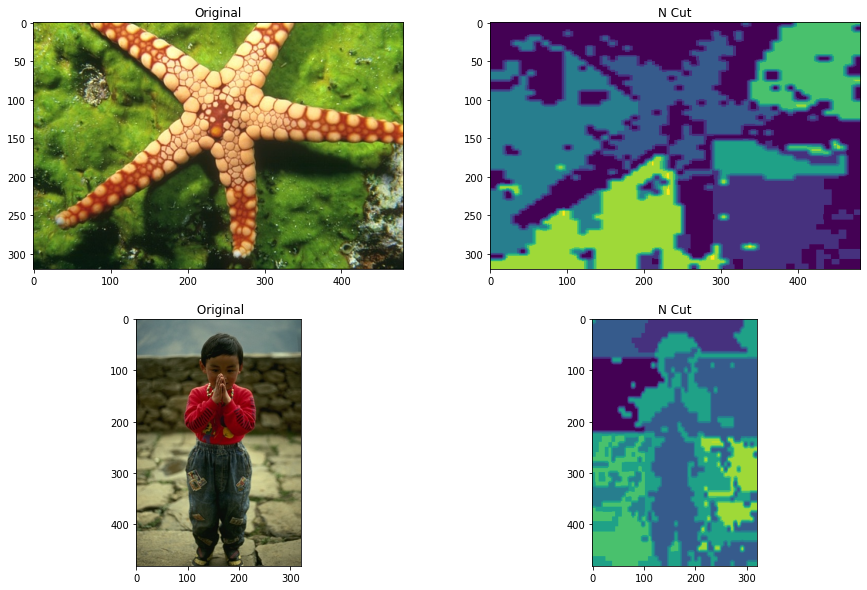

In [18]:
###---Plotting Original and N-Cut Images---###
fig, axs = plt.subplots(2,2, figsize=(15, 10))
axs[0,0].title.set_text("Original")
axs[0,0].imshow(image3_1)

axs[0,1].title.set_text("N Cut")
axs[0,1].imshow(new_Image1)

axs[1,0].title.set_text(" Original")
axs[1,0].imshow(image3_2)

axs[1,1].title.set_text("N Cut")
axs[1,1].imshow(new_Image2)

plt.show()

## 3.4

In [19]:
###---Calculation of the self diffuse for images---###
diffisue_value1,  t_vals1 = selfDiffuse(ncut_graph_matrix_1)
diffisue_value2,  t_vals2 = selfDiffuse(ncut_graph_matrix_2)

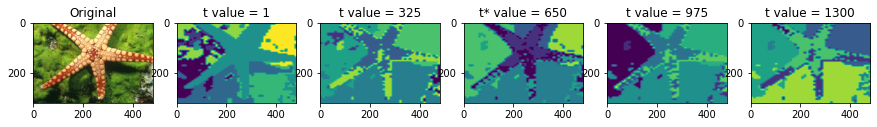

In [20]:
###---Plotting Original and Self diffuse for Image 1 with different t values---###
fig, axs = plt.subplots(1,6, figsize=(15, 10))
axs[0].title.set_text("Original")
axs[0].imshow(image3_1)

for i in range(len(t_vals1)):
    cluster1 = cluster(diffisue_value1[i],7, 25)
    new_Image1 = cluster1[0].reshape((50,50))
    new_Image1 = Image.fromarray(np.uint8(new_Image1))
    new_Image1 = new_Image1.resize((image3_1.size[0], image3_1.size[1]))
    axs[i+1].imshow(new_Image1)
    axs[i+1].title.set_text("t value = " +  str(t_vals1[i]))
axs[3].title.set_text("t* value = "+  str(t_vals1[2]))
plt.show()

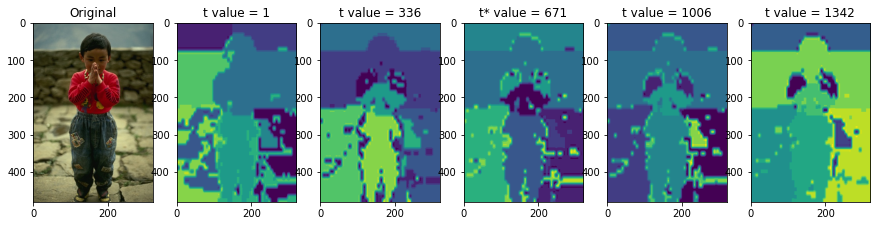

In [21]:
###---Plotting Original and Self diffuse for Image 2 with different t values---###
fig, axs = plt.subplots(1,6, figsize=(15, 10))
axs[0].title.set_text("Original")
axs[0].imshow(image3_2)

for i in range(len(t_vals2)):
    cluster2 = cluster(diffisue_value2[i],10, 15)
    new_Image2 = cluster2[0].reshape((50,50))
    new_Image2 = Image.fromarray(np.uint8(new_Image2))
    new_Image2 = new_Image2.resize((image3_2.size[0], image3_2.size[1]))
    axs[i+1].imshow(new_Image2)
    axs[i+1].title.set_text("t value = "+  str(t_vals2[i]))
axs[3].title.set_text("t* value = "+  str(t_vals2[2]))
plt.show()